### Установка chromedriver

1. Скачать и установить google chrome браузер
2. Посмотреть версию браузера (настройки с троеточием справа -> Help -> About Google Chrome)
3. Скачать и установить google-chrome-driver версии, соответствующей версии браузера https://chromedriver.chromium.org/
4. Распаковать архив и положить в <путь к проекту>/bin/chromedriver
на виндоуз переименовать чтобы не было .exe в расширении, либо в переменной ниже поменять путь к драйверу

In [1]:
pip install -q selenium 

Note: you may need to restart the kernel to use updated packages.


In [2]:
from enum import Enum

### Конфиги

In [3]:
GAME_URL = "chrome://dino/"
CHROMEDRIVER_PATH = "./bin/chromedriver"

In [4]:
class Action(Enum):
    DO_NOTHING = 0
    JUMP = 1
    # TODO: Add action DUSK
    #DUSK = 2 

### Среда

In [5]:
import time
import os
import typing

import cv2

from PIL import ImageGrab

import numpy as np

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

In [6]:
# ОБЯЗАТЕЛЬНО TODO: Подобрать рамку под себя
# Создать environment (см. код ниже)
# Начать игру
# Подобрать различные варианты через ImageGrab.grab(bbox=(0, 210, 550, 350))

In [7]:
SCREEN_BBOX = (0, 210, 550, 350)

In [8]:
# Запускать для подбора бокса ПОСЛЕ создания энвайронмента ниже
# ImageGrab.grab(bbox=SCREEN_BBOX)

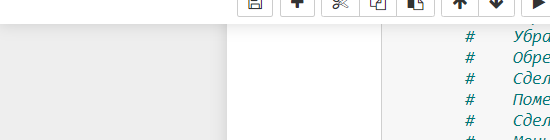

In [9]:
# Запускать для подбора бокса ПОСЛЕ создания энвайронмента ниже
ImageGrab.grab(bbox=SCREEN_BBOX)

In [10]:
class Environment:
    def __init__(
        self, 
        chrome_driver_path: str, 
        game_url: str, 
        speed: typing.Optional[int] = None,
        acceleration: typing.Optional[float] = None,
    ) -> None:
        self.driver = webdriver.Chrome(executable_path=chrome_driver_path)
        # Обязательно TODO: убедиться что эти параметры годятся 
        self.driver.set_window_position(x=-20, y=-20)
        self.driver.set_window_size(550, 450)
        try:
            self.driver.get('chrome://dino')
        except Exception:
            pass   # ignore
        
        if speed:
            self.driver.execute_script(f"Runner.instance_.setSpeed({speed})")
        
        if acceleration:
            self.driver.execute_script(f"Runner.config.ACCELERATION={acceleration}")

    def start_game(self):
        self.driver.find_element(By.TAG_NAME, "body").send_keys(Keys.SPACE)
        time.sleep(2)
        
    def close_game(self):
        self.driver.close()
            
    def perform_action(self, action: Action) -> (typing.Optional[np.ndarray], float):
        if action == Action.DO_NOTHING:
            pass
        elif action == Action.JUMP:
            # TODO: Принять решение не нужна ли тут какая-то пауза убедиться что прыжок закончили
            self.driver.find_element(By.TAG_NAME, "body").send_keys(Keys.SPACE)
            time.sleep(0.5)
        elif action == Action.DUSK:
            # TODO: (ТОЛЬКО ЕСЛИ ДОБАВИЛИ СООТВЕТСТВУЮШИЙ ЭКШН В АГЕНТА) 
            # Если был выбран нырок, то возможно стоит подольше его подержать, а не просто один раз кликнуть
            self.driver.driver.find_element(By.TAG_NAME, "body").send_keys(Keys.ARRAYS_DOWN)
        else:
            raise Exception(f"Unsupported action {action}")
        
        state = self.get_screen()
        if self.has_crashed():
            return None, 0
        else:
            # TODO: Попробовать разные варианты вычисления награды. Может штрафовать за лишние прыжки, например
            reward = self.get_score() / 100
            return state, reward
            
    def has_crashed(self) -> bool:
        return self.driver.execute_script("return Runner.instance_.crashed")
    
    def restart(self) -> None:
        self.driver.execute_script("Runner.instance_.restart()")

    def get_screen(self) -> np.ndarray:
        screen = ImageGrab.grab(bbox=SCREEN_BBOX)
        screen = np.array(screen)
        return self.preprocess_screen(screen)
        
    def preprocess_screen(self, screen: np.ndarray) -> np.ndarray:
        # TODO: Добавить больше препроцессинга. Возможные идеи:
        #    Убрать облака?
        #    Убрать линию "дороги"?
        #    Обрезать изображение?
        #    Сделать черно-белым?
        #    Поменять размер?
        #    Сделать динозавра прямоугольником? :) 
        #    Меньше будущей информации?
        #    Ваши идеи
        return cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
        
    def get_score(self) -> int:
        score_array = self.driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array)
        return int(score)


In [11]:
# TODO: Подобрать какая скорость больше подойдет
# TODO: Принять решение будете ли использовать ускорение или лучше задать его в ноль (тогда не будет птичек еще)

environment = Environment(CHROMEDRIVER_PATH, GAME_URL)

<ipython-input-10-6ae2d377bfdc>:9: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.driver = webdriver.Chrome(executable_path=chrome_driver_path)


In [12]:
environment.start_game()

In [13]:
environment.perform_action(Action.JUMP)

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [238, 238, 238, ..., 255, 255, 255],
        [238, 238, 238, ..., 255, 255, 255],
        [238, 238, 238, ..., 255, 255, 255]], dtype=uint8),
 0.17)

In [14]:
environment.perform_action(Action.DO_NOTHING)

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [238, 238, 238, ..., 255, 255, 255],
        [238, 238, 238, ..., 255, 255, 255],
        [238, 238, 238, ..., 255, 255, 255]], dtype=uint8),
 0.17)

### DQN

In [15]:
import torch
import torch.nn as nn

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DQN(nn.Module):
    def __init__(self, screen_width, screen_height, action_count):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        conv1_out_width = self.conv2d_size_out(screen_width, 5, 2)
        conv1_out_height = self.conv2d_size_out(screen_height, 5, 2)
        
        self.flatten = nn.Flatten()
        self.head = nn.Linear(conv1_out_width * conv1_out_height * 16, action_count)
        
    def conv2d_size_out(self, size: int, kernel_size: int, stride: int) -> int:
        return (size - (kernel_size - 1) - 1) // stride  + 1
    
    def forward(self, x):
        # TODO: Добавить различные сверточные слои / функции активации / и т.д.
        x = x.to(device)
        backbone = self.flatten(self.conv1(x))
        return self.head(backbone)

In [17]:
screen_height = SCREEN_BBOX[3] - SCREEN_BBOX[1]
screen_width = SCREEN_BBOX[2] - SCREEN_BBOX[0]

screen_height, screen_width

(140, 550)

In [18]:
policy_net = DQN(screen_height, screen_width, len(Action)).to(device)

In [19]:
state = torch.from_numpy(environment.get_screen()).float()
batch_state = state.unsqueeze(0).unsqueeze(0)

batch_state.shape

torch.Size([1, 1, 140, 550])

In [20]:
policy_net(batch_state)

tensor([[129.7260,  -9.6186]], grad_fn=<AddmmBackward>)

### Агент

In [21]:
import random 
import collections as col


class Agent:
    
    # TODO: ВАЖНО: Подобрать параметры ниже    
    GAMMA = 0.99

    EXPLORATION_STEPS_COUNT = 200   # Количество шагов, когда совершаем ТОЛЬКО exploration 
    EPS_INITIAL = 0.9   # Начальное значение EPS, после которого начинаем подключать exploitation
    EPS_FINAL = 0.05    # Минимальное значение EPS, до которого дойдем
    EPS_DECAY_DELTA = 0.05   # Величина, на которую будем уменьшать EPS
    EPS_DECAY_STEPS_COUNT = 100  # Через сколько шагов будем снижать EPS
    
    def __init__(self) -> None:
        self.eps = 1    # По началу только exploration
        self.made_steps_count = 0
        self.n_actions = len(Action)
        self.policy_net = DQN(screen_height, screen_width, self.n_actions).to(device)
        self.optimizer = torch.optim.RMSprop(policy_net.parameters())
    
    def select_action(self, state: np.ndarray) -> Action:
        self.made_steps_count += 1
        
        # Пока еще только exploration
        if self.made_steps_count < self.EXPLORATION_STEPS_COUNT:
            self.eps = 1
        # Начинаем подключать exploitation
        elif self.made_steps_count == self.EXPLORATION_STEPS_COUNT:
            self.eps = self.EPS_INITIAL
        # Каждые EPS_DECAY_STEPS_COUNT шагов на константу уменьшаем eps если он получится не меньше чем EPS_FINAL
        elif self.made_steps_count % self.EPS_DECAY_STEPS_COUNT == 0 \
                and self.eps - self.EPS_DECAY_DELTA >= self.EPS_FINAL:
            self.eps -= self.EPS_DECAY_DELTA                        
        
        exploit_prob = random.random()
        if exploit_prob > self.eps:
            with torch.no_grad():
                # Сеть ожидает что у нас обязательно будет размерность для батча. Создаем фиктивную размерность 
                # Также создаем фиктивную размерность для числа каналов
                state_batch = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)
                batch_action_rewards = policy_net(state_batch)
                batch_argmax_actions = batch_action_rewards.max(1).indices
                # Взяли нулевой элемент, т.к. у нас батч всего из одного элемента
                action_ind = batch_argmax_actions.tolist()[0]
        else:
            action_ind = random.randrange(self.n_actions)        
        return Action(action_ind)    
    
    def update_reward(self, state: np.ndarray, action: Action, next_state: np.ndarray, reward: int) -> None:
        state_batch = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)
        next_state_batch = torch.from_numpy(next_state).float().unsqueeze(0).unsqueeze(0)
        # Индексы действий что мы проделали. Используется чтобы достать текушие оценки Q для проделанных действий
        action_batch = torch.from_numpy(np.array([action.value])).unsqueeze(0)
        #reward_batch = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0)

        # Получаем текущее "жадное" действие для уравнения Беллмана
        with torch.no_grad():
            next_state_values = policy_net(next_state_batch).max(1)[0]
            expected_state_action_values = (next_state_values * GAMMA) + reward

        # Получаем текущее значение Q для проделанного действия    
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    

In [22]:
agent = Agent()

### Цикл обучения

In [25]:
# TODO: число эпизодов подобрать
episodes_count = 50

for episode_num in range(episodes_count):
    print(f"Running episode {episode_num}")
    environment.restart()
    environment.start_game()
    
    while not environment.has_crashed():
        state = environment.get_screen()
        if not environment.has_crashed(): 
            action = agent.select_action(state)
            next_state, reward = environment.perform_action(action)
            # Не сломались пока выполняли действие
            if next_state is not None:
                agent.update_reward(state, action, next_state, reward)
            
# TODO: Если так ничего хорошего не выйдет, то делать Replay Memory
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Running episode 0


NameError: name 'GAMMA' is not defined